In [9]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import torch
import torch.nn as nn

import torchvision

Plan for today ([VAE](https://arxiv.org/pdf/1312.6114.pdf))

- Discuss the problem formulation
- Discuss two options, how we can learn generative distribution
- Implement experiments on MNIST
- (briefly) discuss possible extension on larger dataset
- Implement 2 methods to evaluate likelihood

In [10]:
train_dset = torchvision.datasets.MNIST('./', download=True, train=True)
test_dset = torchvision.datasets.MNIST('./', download=True, train=False)

#reshape
X_train = test_dset.data.float().numpy().reshape(-1, 784)/255.
X_test = test_dset.data.float().numpy().reshape(-1, 784)/255.

#binarize
np.random.seed(777)
X_train = np.random.binomial(1, X_train)
X_test = np.random.binomial(1, X_test)

train_dset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float())
test_dset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float())

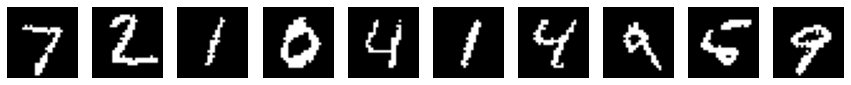

In [11]:
# take a look a the images
fig, ax = plt.subplots(ncols=10, figsize=(15, 5))
for i in range(10):
  ax[i].imshow(train_dset[i][0].reshape(28, 28), cmap='gray')
  ax[i].axis('off')

# Probabilistic model

$$
z \sim p(z)\\
x \sim p_\theta(x|z)
$$
and hence
$$
p_{\theta}(x) = \int p_\theta(x|z)p(z)dz
$$


* We can use standard normal **prior** (it is a usual thing to do in practice)

$$
p(z) = \mathcal{N}(z|0, I), \\
$$

* For black-n-white images we can use Bernoulli **likelihood**:
$$
p_{\theta}(x|z) = \mathcal{Be}(x|\mu_{\theta}(z))
$$

where $\mu_{\theta}(z)$ is a function, modeled by NN, which outputs vector of probabilities (aka parameters of Bernoulli ditribution). We will call it **decoder**.



# Training

We do not observe $\theta$ and $z$. How to estimate them from data?

### Option 1. Do not care about $z$.

So, let us assume that distribution or even point estimate of latent variables $z$ is not in our interest.

We only want to find MLE for $\theta$, in order to be able to sample $x$.

**Task:** Implement the class for decoder - NN, which takes as input latent vector $z$ and returns parameters of the generative distribution $p_{\theta}(x|z)$.


In [12]:
class Decoder(nn.Module):
  def __init__(self, z_dim, x_dim, h_dim):
    super(Decoder, self).__init__()
    self.z_dim = z_dim
    self.net = nn.Sequential(
        nn.Linear(z_dim, h_dim),
        nn.LeakyReLU(),
        nn.Linear(h_dim, h_dim),
        nn.LeakyReLU()
    )

    self.mu = nn.Sequential(
        nn.Linear(h_dim, x_dim),
        nn.Sigmoid()
    )
    # YOUR CODE HERE
    
  def forward(self, z):
    """
    Make forward pass and return parameters of the generative distribution p(x|z)
    """
    h = self.net(z)
    mu = self.mu(h)
    return mu 
   
    # YOUR CODE HERE
   

  def sample(self, N, device='cpu'):
    z = torch.randn((N, self.z_dim), device=device)
    mu = self(z)
    samples = torch.bernoulli(mu)
    return samples




**Objective:** 

$$
\log p_{\theta}(x) = \log \int p_\theta(x|z)p(z)dz = \log \mathbb{E}_{p(z)}p_{\theta}(x|z) \geq \mathbb{E}_{p(z)} \log p_{\theta}(x|z)
$$

$$
Loss(X, \theta) = - \sum_{n=1}^N \mathbb{E}_{p(z)} \log p_{\theta}(x_n|z) \rightarrow min_{\theta}
$$

**Task:** Fill in the function below. It should caculate log likelihood of the bernoulli distribution with parameteres $p$ over the batch $x$. 

For 1 object it can be computed as:
$$
log lik = \sum_{k=1}^K \left(x_k \log p_k + (1-x_k) \log (1-p_k) \right)
$$

In [13]:
def Bernoulli_loglik(x, p, dim=1):
  """
  Compute log likelihood of the bernoulli distribution 
  dim --- dimention to sum over
  """
  probs = torch.clamp(p, min=1e-5, max=1.-1e-5)
  # YOUR CODE HERE
  log_bernoulli = x * torch.log(probs) + (1.- x) * torch.log(1. - probs)
  return torch.sum(log_bernoulli, dim)

  




So, the training procedure (for a given mini-batch) is the following:
* Sample $z$
* Decode it, to get parameters of the Bernoulli distrribution
* Calculate loss (negative log likelihood)

In [18]:
from IPython.display import clear_output
def train_decoder(train_loader, max_epoch, decoder):
  hist = []
  optim = torch.optim.Adam(decoder.parameters(), lr=1e-4)
  for e in range(max_epoch):
    tot_loss = 0.
    for X, in train_loader:
      optim.zero_grad()
      X = X.to(device)
      N = X.shape[0]
      z = torch.randn((N, decoder.z_dim), device=device)
      p_curr = decoder(z)
      loss = -Bernoulli_loglik(X,p_curr).mean()
      loss.backward()
      optim.step()

      tot_loss += loss.item()/len(train_loader)
      
      # YOUR CODE HERE
     
    hist.append(tot_loss)
    plt.plot(hist)
    plt.yscale('log')
    plt.pause(0.3);
    clear_output(wait=True);



In [15]:
device = 'cuda'
train_loader = torch.utils.data.DataLoader(train_dset, 250)
model = Decoder(40, 784, 300)
model = model.to(device)

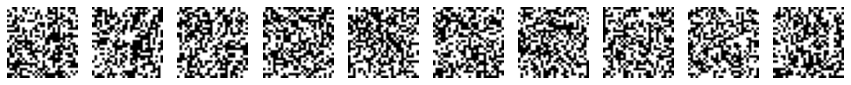

In [16]:
# take a look a the samples (before trianing)
Xs = model.sample(10, device)
fig, ax = plt.subplots(ncols=10, figsize=(15, 5))
for i in range(10):
  ax[i].imshow(Xs[i].data.cpu().reshape(28, 28), cmap='gray')
  ax[i].axis('off')

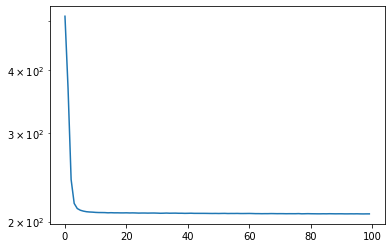

In [19]:
#train
train_decoder(train_loader, 100, model)

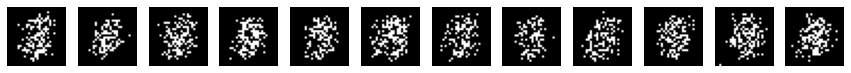

In [20]:
# take a look a the samples (after trainig)
K = 12
Xs = model.sample(K, device)
fig, ax = plt.subplots(ncols=K, figsize=(15, 5))
for i in range(K):
  ax[i].imshow(Xs[i].data.cpu().reshape(28, 28), cmap='gray')
  ax[i].axis('off')

### Option 2. Time to care about $z$

* True posterior is intractable 
* So, let's take variational posterior:
$$
q(z) \approx p(z|x)
$$

We can get variational lower bound on the log likelihood (ELBO):

$$
    \log p(x) = D_{\text{KL}} (q(z) \| p(z|x)) + \mathbb{E}_{q(z)} \log \frac{p(x, z)}{q(z)} \geq \mathbb{E}_{q(z)} \log \frac{p_{\theta}(x| z) p(z)}{q(z)} =\mathcal{L}
$$

It is common to rewrite it as (Reconstruction loss and KL):
$$
\mathcal{L} =\mathbb{E}_{q(z)}\log p_{\theta}(x| z) - D_{\text{KL}}(q(z) \| p(z)) \rightarrow \max_{q, \theta}
$$

**We still have a problem:**\
We have separate $z_n$ for each observations $x_n$. Therefore, we need to learn $N$ posterior distributions $q_1(z), \cdots, q_N(z)$

**Solution:**\
Amortized VI, that is we will learn **one** function, which will "encode" image $x$ and return variational posterior (or its parameters):

$$
q_n(z) = q_{\phi}(z|x_n)
$$

Ofc. this function will be a NN, referred to as **encoder**, it will return parameters of the gaussian distribution:

$$
q_{\phi}(z|x_n) = \mathcal{N}(z|\mu_{\phi}(x_n), \sigma^2_{\phi}(x_n))
$$

**Task:** Implement encoder. It is a NN, which takes as input an object $x$ and produce parameters of the variational posterior
- We will use Gaussian with diagonal covariance matrix
- It is better to learn $\log \sigma^2$ instead of $\sigma^2$ for numerical stability

In [26]:
class Encoder(nn.Module):
  def __init__(self, z_dim, x_dim, h_dim):
    super(Encoder, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(x_dim, h_dim),
        nn.LeakyReLU(),
        nn.Linear(h_dim, h_dim),
        nn.LeakyReLU()
    )

    self.mu = nn.Sequential(
        nn.Linear(h_dim, z_dim)
    )

    self.logvar = nn.Sequential(
        nn.Linear(h_dim, z_dim)
    )

    # YOUR CODE HERE
    
  def forward(self, x):
    h = self.net(x)
    mu = self.mu(h)
    logvar = self.logvar(h)
    return mu, logvar
    # YOUR CODE HERE
    


The final objective:
$$
    \max_{\theta, \phi} \mathcal{L} = \max_{\theta, \phi}  \mathbb{E}_{q_{\phi}(z|x)}\log p_{\theta}(x| z) - D_{\text{KL}}(q_{\phi}(z|x) \| p(z))
$$

- We can explicitly compute KL term for gaussian case
- We will have to use reparametrixation trick to for the reconstruction term

**Task:** Implement function, which compute KL between two gaussians distributions.

For 1-d case closed-form formula is the following:

$$
D_{\text{KL}}(p, q) = \log \frac{\sigma_q}{\sigma_p} + \frac{\sigma_p^2 + (\mu_p - \mu_q)^2}{2 \sigma_q^2} - \frac12
$$

In [22]:
def gaus_kl(p_mu, p_logvar, q_mu, q_logvar):
  res = q_logvar - p_logvar + torch.exp(p_logvar - q_logvar) - 1
  res += (q_mu - p_mu).pow(2) / (torch.exp(q_logvar)+1e-5)
  return res.sum(1)
  # YOUR CODE HERE
  

**Task:** Implement trainig procedure


The algorithm would be (for a given mini-batch)
* Encode $x$ to get parameters of the variational posterior $q_{\phi}(z|x)$
* Compute KL term
* Sample $z$ from variational posterior 
* Decode it to get parameters of the Bernoulli ditribition
* Compute reconstruction term

In [27]:
def reparametrize(z_mu, z_logvar):
  # sample z from gaussioan distribution
  eps = torch.randn(z_mu.shape, device=z_mu.device)
  z_sample = z_mu + torch.exp(0.5*z_logvar)*eps
  return z_sample

def eval_elbo(X, encoder, decoder):
  """
  Compute reconstruction loss and KL term for a given mini-batch
  """
  # YOUR CODE HERE

  # encode X
  z_mu, z_logvar = encoder(X)
  
  # compute KL
  kl = gaus_kl(z_mu, z_logvar, torch.zeros_like(z_mu), torch.zeros_like(z_logvar))

  # sample z from var posterior
  z_sample = reparametrize(z_mu, z_logvar)
  
  # decode z
  p_curr = decoder(z_sample)
  rec_loss = -Bernoulli_loglik(X, p_curr)
  
  return rec_loss.mean(), kl.mean()


def train_vae(train_loader, max_epoch, encoder, decoder):
  kl_hist = []
  rec_hist = []
  all_params = list(encoder.parameters()) + list(decoder.parameters())
  optim = torch.optim.Adam(all_params, lr=1e-4)
  for e in range(max_epoch):
    tot_rec = 0.
    tot_kl = 0.
    for X, in train_loader:
      optim.zero_grad()
      X = X.to(device)
      rec_loss, kl = eval_elbo(X, encoder, decoder)
      loss = rec_loss + kl #* alpha
      loss.backward()
      optim.step()

      tot_rec += rec_loss.item() / len(train_loader)
      tot_kl += kl.item() / len(train_loader)
      # YOUR CODE HERE
      


    kl_hist.append(tot_kl)
    rec_hist.append(tot_rec)
    fig, ax = plt.subplots(ncols=2, figsize=(10,5))
    ax[0].plot(kl_hist)
    ax[0].set_title('kl')
    ax[0].set_yscale('log')
    ax[1].plot(rec_hist)
    ax[1].set_title('rec')
    ax[1].set_yscale('log')
    plt.pause(0.3);
    clear_output(wait=True);


In [28]:
enc = Encoder(40, 784, 300)
dec = Decoder(40, 784, 300)
enc.to(device)

dec.to(device)

Decoder(
  (net): Sequential(
    (0): Linear(in_features=40, out_features=300, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (mu): Sequential(
    (0): Linear(in_features=300, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

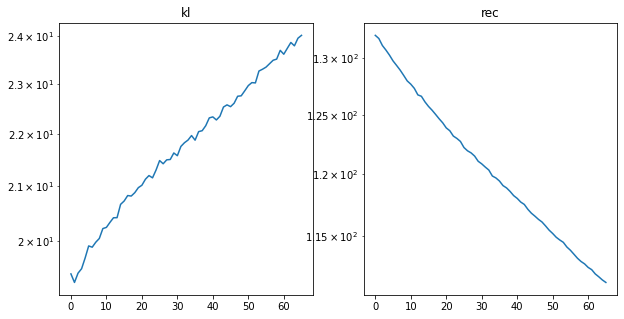

KeyboardInterrupt: ignored

In [34]:
train_vae(train_loader, 100, enc, dec)

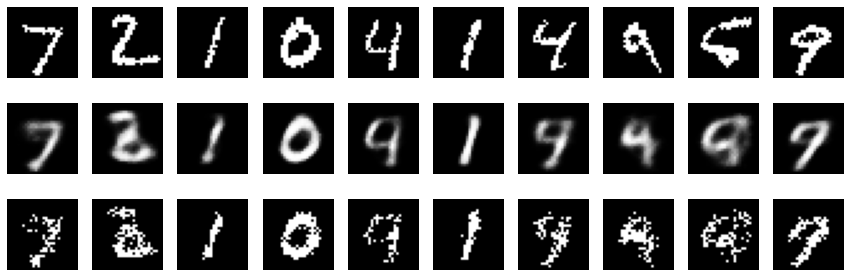

In [35]:
# take a look a the reconstructions
fig, ax = plt.subplots(nrows=3, ncols=10, figsize=(15, 5))
for i in range(10):
    X_real = test_dset[i][0]
    z_mu, z_logvar = enc(X_real.to(device))
    z_sample = reparametrize(z_mu, z_logvar)
    p_curr = dec(z_sample)
    samples = torch.bernoulli(p_curr)

    ax[0,i].imshow(X_real.data.cpu().reshape(28, 28), cmap='gray')
    ax[1,i].imshow(p_curr.data.cpu().reshape(28, 28), cmap='gray')
    ax[2,i].imshow(samples.data.cpu().reshape(28, 28), cmap='gray')

for a in ax.flatten(): a.axis('off')

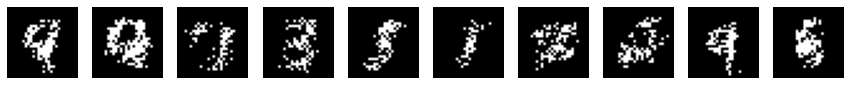

In [36]:
# take a look a the samples
Xs = dec.sample(10, device)
fig, ax = plt.subplots(ncols=10, figsize=(15, 5))
for i in range(10):
  ax[i].imshow(Xs[i].data.cpu().reshape(28, 28), cmap='gray')
  ax[i].axis('off')

In [37]:
# interpolate
def plot_interpolation(x1, x2):
  fig, ax = plt.subplots(ncols=10, figsize=(15, 5))
  z_1_e = enc(x1.to(device))
  z_2_e = enc(x2.to(device))
  z_1 = reparametrize(z_1_e[0], z_1_e[1]).view(1,-1)
  z_2 = reparametrize(z_2_e[0], z_2_e[1]).view(1,-1)

  alpha = torch.linspace(0., 1., 10).to(device).view(10, 1)
        
  interpolations_z = (z_1 * alpha + z_2 * (1 - alpha))
  
  interpolations_x = dec(interpolations_z)
  for i in range(10):
    ax[i].imshow(interpolations_x[i].data.cpu().reshape(28, 28), cmap='gray')
    ax[i].axis('off')

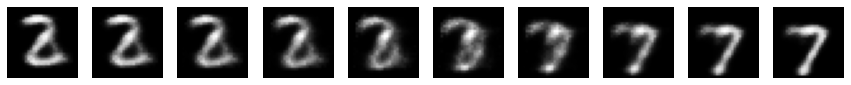

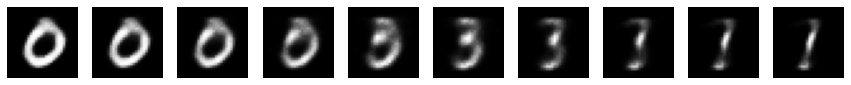

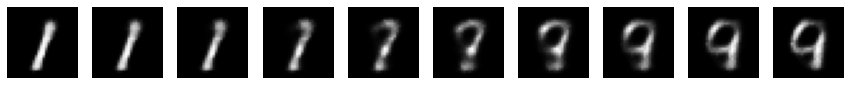

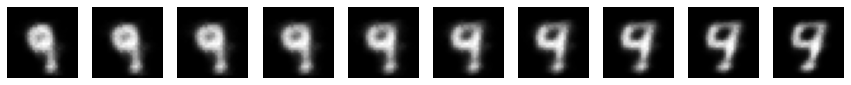

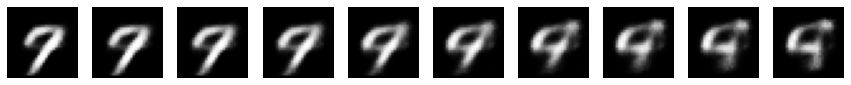

In [38]:
for k in range(5):
  plot_interpolation(test_dset[k*2][0], test_dset[k*2+1][0])

How to make it better:

- IWAE (see below), essentially it means using tighter lower bound during training ([paper](https://arxiv.org/abs/1509.00519))
- Anneal the weight of KL term: [Beta-VAE](https://openreview.net/references/pdf?id=Sy2fzU9gl), [Taming VAE](https://arxiv.org/abs/1810.00597)
- More expressive prior (e.g. [VampPrior](https://arxiv.org/abs/1705.07120), [VAE-CRP](https://arxiv.org/pdf/1703.07027.pdf))
- More expressive posterior ([GLF](https://arxiv.org/pdf/1905.10485.pdf), [IAF-VAE](https://arxiv.org/abs/1606.04934))
- Hierarchical structure [BIVA](https://arxiv.org/abs/1902.02102)
- Play with architecture (empirically observed tricks):
  - Res blocks
  - [Weight normalization](https://arxiv.org/abs/1602.07868) instead of BatchNorm
  - Spectral Regularization 
  - Add [Perceptual Loss](https://arxiv.org/abs/1610.00291)
  - Autoregression decoder 

The most recent combination of trick,[NVAE](https://arxiv.org/abs/2007.03898), produces decent high-dimetional samples.

![](https://raw.githubusercontent.com/NVlabs/NVAE/master/scripts/celebahq.png)


## Evaluating VAE


We want to estimate log-likelihood on validation. There are 2 options:

1. Straightforward Monte-Carlo:

$$p_\theta(x) \approx \frac{1}{K} \sum\limits_{k = 1}^K p_\theta(x | z_i), z_k \sim p(z)$$

2. Importance Sampling.

- good choice of the proposal distribution is known to decrease the variance of the estimator
- we have a good proposal - variational posterior


$$p_\theta(x) = \mathbb{E}_{p(z)} p_\theta(x | z) = \mathbb{E}_{q_\phi(z | x)} \frac{p_\theta(x | z) p(z)}{q_\phi(z | x)} \approx \frac{1}{K} \sum\limits_{k = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)}, \,\, z_k \sim q_\phi(z | x)$$


**But** (as usual)

- We have high-dimentional objects, and the likelihood will probably be a small number
- We have to multiply likelihoods for all objects in the validation data

So, take the logarithm for numerical stability!

1. Monte-Carlo
$$\log p_\theta(x) \approx \log \frac{1}{K} \sum\limits_{k = 1}^K p_\theta(x | z_i), z_k \sim p(z)$$


2. Importance Sampling
$$\log p_\theta(x) \approx \log \frac{1}{K} \sum\limits_{k = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)}, \,\, z_k \sim q_\phi(z | x)$$

**Task:** Implement 1st method for log likelihood

**Hint:**  Use `torch.logsumexp()` function to convert  $\sum \log p$ into $\log \sum p$.

In [39]:
def loglik_MC(X, encoder, decoder, K):
    N = X.shape[0]
    p_curr = decoder.sample(N*K, device)
    p_curr = p_curr.reshape(K, N, -1)
    X = X.reshape(1, N, -1)

    loglik = Bernoulli_loglik(X, p_curr, 2)
    loglik = torch.logsumexp(loglik, 0) - np.log(K)
    return loglik.data.cpu()

**Task:** Implement IWAE

In [40]:

def gauls_log_prob(x, mu, logvar, dim=-1):
  log_p = -0.5 * ( logvar + torch.pow( x - mu, 2 ) / torch.exp( logvar ) )
  return log_p.sum(dim)

  
def loglik_IWAE(X, encoder, decoder, K):
    # X (N x X_dim)
    N = X.shape[0]

    # Get proposal and sample from it K times
    mu_z, logvar_z = encoder(X) 
    z_hat = reparametrize(mu_z.repeat((K, 1, 1)), logvar_z.repeat((K, 1, 1))) #(K, N, x_dim)
  
    # log prior
    log_p = gauls_log_prob(z_hat, torch.zeros_like(z_hat), torch.zeros_like(z_hat), 2)

    # log posterior
    log_q = gauls_log_prob(z_hat, mu_z.unsqueeze(0), logvar_z.unsqueeze(0), 2)

    # generative distr
    p_curr = decoder(z_hat.reshape(N*K, -1))
    log_p_x = Bernoulli_loglik(X.reshape(1, N, -1), p_curr.reshape(K, N, -1), 2)

    log_lik = torch.logsumexp(log_p_x + log_p - log_q, 0) - np.log(K)
    
    return log_lik.data.cpu()

In [41]:
# Compute for the whole test dataset
def eval_loglik(K, test_loader, batch_fn):
  curr = []
  with torch.no_grad():
    for X, in test_loader:
      curr.append(batch_fn(X.to(device), enc, dec, K))
    return -torch.cat(curr).mean()

In [42]:
test_loader = torch.utils.data.DataLoader(test_dset, 50)
MC_P = []
IWAE_P = []
K_vals = [1, 10, 100, 1000, 2000]

for K in K_vals:
  MC_P.append(eval_loglik(K, test_loader, loglik_MC))
  IWAE_P.append(eval_loglik(K, test_loader, loglik_IWAE))

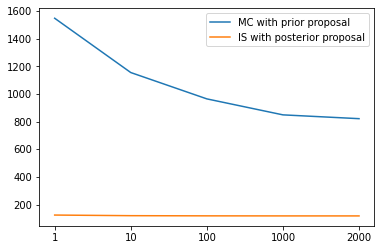

In [43]:
plt.plot(MC_P, label='MC with prior proposal')
plt.plot(IWAE_P, label='IS with posterior proposal')
plt.legend()
plt.xticks(range(len(K_vals)), labels=K_vals);